# NRC Emotions lexicon based text and sentiment analysis between two text corpuses
This analyses the two corpuses PA and YT on the basis of association of words with eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The [NRC lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) is used.


# Load the python packages and initialize global variables

In [1]:
import docx
import gensim
import os
import pandas as pd
import nltk
import numpy as np
import re
import spacy
import sys
from scipy.stats import mannwhitneyu
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

nlp = spacy.load('en', disable=['parser', 'ner'])
sys.getdefaultencoding()

NRC_EMOTION_LEXICON_PATH = "Input/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
nouns = ['NNS', 'NNPS']  # + 'NN' + 'NNP',
adjectives = ['JJ', 'JJR', 'JJS']

OUTPUT_PATH = "Output"
PA_CORPUS_TEXT = "PACorpus.txt"
YT_CORPUS_TEXT = "YTCorpus.txt"
INPUT_PATH = "Input"
INPUT_FILE = "US3_ALL_TRANSCRIPTS.docx"
WORD_LIST = ['i', 'me', 'our', 'my', 'we', 'us', 'you', 'your', 'she', 'her', 'he', 'him', 'his', 'they','them', 'their']

# Read given input document file 
Read the given input file and return list of lines

In [2]:
def read_input_file(file_path):
    doc = docx.Document(file_path)
    total_lines = list()
    for i in doc.paragraphs:
        total_lines.append(i.text)
    return total_lines
filename = 'Input/US3_ALL_TRANSCRIPTS.docx'
lines = read_input_file(filename)

# Grouping of Corpuses
This method groups the given text into two groups (PA and YT) and removes unnecessary lines and characters. We have list of sentences read from the docx file as argument.

In [3]:
def group_to_corpuses(lines_in_input):
    yt_group = list()
    pa_group = list()
    
    pa_grouped_by_participant = dict()
    yt_grouped_by_participant = dict()

    initial_group_flag = None
    regex = re.compile('^P[0-9]+$')
    participant = 'P01'
    for line in lines_in_input:
        # remove empty line
        if not line.strip():
            continue
        # remove line starting with Joni or Jim
        if line.strip().startswith("Joni: ") or line.strip().startswith("Jim:"):
            continue
            
        # remove line starting with R: or R : since it is the interviwer part. There is no uniformity in starting character
        # so I have to use different srating characters
        if line.strip().startswith("R:") or line.strip().startswith("R: ") or line.strip().startswith("R :"):
            continue
            
        # If R: is present in a group of lines, remove the one sentence starting with R: and leave others
        if "R:" in line:
            line_list = line.splitlines()
            lines_list = line_list
            for single_line in line_list:
                if single_line.startswith("R:"):
                    lines_list.remove(single_line)
            line = ",".join(lines_list)

        # some line have P0, P1, (P+Number) so we use regex to find matching and remove those sentences
        if re.match(regex, line):
            participant = line
            continue
        # some line with date and time stamp information of inverview are removed
        if line.strip().startswith('2018-11-') or line.strip().startswith('Total experiment talk time:'):
            continue
            
        # regex removing text between brackets
        line = re.sub(r'\[[^()]*\]', '', line)

        # replace special characters given below with comma
        line = line.replace('...', ' ,')
        line = line.replace('…', ' ,')

        # this is a case of non-alphanumeric character present in sentence which does not start with P: or YT or PA
        # convert non-alphanumeric to numeric and remove sentences starting with R : or R4. or P10(that is left over 
        # due to non-alpha numeric character)
        if not line.strip().startswith("P:") and not line.strip().startswith('YT') and not line.strip().startswith(
                'PA'):
            line = "".join([i if ord(i) < 128 else ' ' for i in line])
            if line.strip().startswith("R :") or line.strip().startswith("R4.") or line.strip().startswith("P10"):
                continue

        # check if line start with YT or PA
        # if it starts with YT set group flag to YT and keep all sentences to YT group until flag is changed to PA
        # if flag is PA, keep all sentences to PA group until flag is changed to YT
        if line.strip().lower() == 'yt':
            initial_group_flag = 'yt'
            continue
        elif line.strip().lower() == 'pa':
            initial_group_flag = 'pa'
            continue
        elif line:
            if initial_group_flag == 'pa':
                line_group = pa_grouped_by_participant.get(participant, [])
                line_group.append(line)
                pa_grouped_by_participant.update({participant: line_group})
                pa_group.append(line)
            else:
                line_group = yt_grouped_by_participant.get(participant, [])
                line_group.append(line)
                yt_grouped_by_participant.update({participant: line_group})
                yt_group.append(line)
    return pa_group, yt_group, pa_grouped_by_participant, yt_grouped_by_participant
pa_group, yt_group, pa_grouped_by_participant, yt_grouped_by_participant = group_to_corpuses(lines)

# Write to each corpus file 
write the classified text to each corpus files

In [4]:
def write_to_corpus_file(data, _type=PA_CORPUS_TEXT):
    text_file_path = os.path.join(OUTPUT_PATH, _type)
    with open(text_file_path, 'w') as outfile:
        for line in data:
            outfile.write("%s\n" % line)

In [5]:
# write to pa corpus text file
write_to_corpus_file(pa_group, PA_CORPUS_TEXT)

# write to yt corpus text file
write_to_corpus_file(yt_group, YT_CORPUS_TEXT)

# Tokenize and Clean-up
We consider:
- Each text is a list of sentences
- Each sentence is a list of tokens
- Each token is a tuple of three elements: a word form (the exact word that appeared in the text), a word lemma (a generalized version of the word), and a list of associated tags

Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether. Gensim’s ```simple_preprocess()``` is great for this. Additionally I have set ```deacc=True``` to remove the punctuations.

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Lemmatization
Lemmatization convert words to its root word. This method lemmatizes the tokenized words and joins them into sentences.
For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the further step) will be denser with lesser columns.

We can expect better topics to be generated in the end.

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join(
            [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Splitting
Splitter class use english pickle splitter to split paragraph into list of sentences and tokenize each sentence into words using ```nltk.tokenize```

In [8]:
class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self, text):
        """
        input format: a paragraph of text
        output format: a list of lists of words.
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        """
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences

# POS Tagging
A POS tag is a tag that indicates the part of speech for a word. POS tags provide linguistic signal on how a word is being used within the scope of a phrase, sentence, or document. 

What I mean by this is that the word “run” can be used as a verb “I run 5 miles every day” or as a noun “I went for a run”. Sometimes the POS is very very useful in cases where it distinguishes the word sense (the meaning of the word). In other cases, it is still useful in explaining the syntactic role of a word and we can often infer semantic information from this due to our knowledge of how this syntactic role is commonly used semantically.

If we donot POS tag, performance on tasks like word sense disambiguation and sentiment analysis would be radically worse (as there are many results that show that POS provides linguistic signal that is essential for strong performance on these tasks).

Parts of Speech tagging of splitted words in a sentence by ```Splitter()```.

In [9]:
class POSTagger(object):
    def __init__(self):
        pass

    def pos_tag(self, sentences):
        """
        input format: list of lists of words
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        output format: list of lists of tagged tokens. Each tagged tokens has a
        form, a lemma, and a list of tags
            e.g: [[('this', 'this', ['DT']), ('is', 'be', ['VB']), ('a', 'a', ['DT']), ('sentence', 'sentence', ['NN'])],
                    [('this', 'this', ['DT']), ('is', 'be', ['VB']), ('another', 'another', ['DT']), ('one', 'one', ['CARD'])]]
        """

        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        # adapt format
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos

# Dictionary Tagging of NRC emotion lexicon 
Read the NRC emotion lexicon and tag the words with emotion and lexicon. Use this tagged data to find the emotions and sentiment of each word of the POS tagged PA and YT corpus sentences.

In [10]:
class DictionaryTagger(object):
    def __init__(self, file_path):
        self.dictionary = dict()
        self.max_key_size = 0
        with open(file_path, "r", encoding="utf-8") as nrc_file:
            for line in nrc_file.readlines():
                if not line.strip():
                    continue
                line = re.sub(r'\s+', '\t', line)
                splited = line.replace("\n", "").split("\t")
                word, emotion, value = splited[0], splited[1], splited[2]

                if word in self.dictionary.keys():
                    self.dictionary[word].append((emotion, int(value)))
                else:
                    self.dictionary[word] = [(emotion, int(value))]

    def tag(self, postagged_sentences):
        return [self.tag_sentence(sentence) for sentence in postagged_sentences]

    def tag_sentence(self, sentence, tag_with_lemmas=False):
        """
        the result is only one tagging of all the possible ones.
        The resulting tagging is determined by these two priority rules:
            - longest matches have higher priority
            - search is made from left to right
        """
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while i < N:
            j = min(i + self.max_key_size, N)  # avoid overflow
            tagged = False
            while j > i:
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                expression_lemma = ' '.join([word[1] for word in sentence[i:j]]).lower()
                if tag_with_lemmas:
                    literal = expression_lemma
                else:
                    literal = expression_form
                if literal in self.dictionary:
                    # self.logger.debug("found: %s" % literal)
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, expression_lemma, taggings)
                    if is_single_token:  # if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][2]
                        tagged_expression[2].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence

# MannWhitney-U test
Perform MannWhitney-U test to compare the emotions and sentiments between PA corpus and YT corpus

In [11]:
def mann_whitney_u_test(group_pa, group_yt):
    print("Mann Whitney-u Test:")
    output = dict()
    for key, yt_value in group_yt.items():
        pa_value = group_pa.get(key)
        try:
            mw_stat, mw_p = mannwhitneyu(pa_value, yt_value, use_continuity=False, alternative="greater")
        except ValueError:
            mw_stat = -1  # in case of ties, Mann-Whitney cannot rank, and so cannot calculate U
            mw_p = -1
        output.update({
            key: {
                'PA': sum(pa_value),
                'YT': sum(yt_value),
                'U-value': mw_stat,
                'P-value': round(mw_p, 8)
            }
        })
    return output

# Sentiment and Emotion Score Calculation
Get sentiments and emotions for each word from dictionary tagged data.

In [12]:
def get_sentiment(sentiment):
    if not isinstance(sentiment, tuple):
        return dict()
    results = dict()
    if sentiment[1]:
        results.update({sentiment[0]: sentiment[1]})
    return results

Aggregate the sentiment score and emotions

In [13]:
def sentiment_score(dict_tagged_sentences):
    emotions = dict()
    emotions_words_vector = dict()
    for sentence in dict_tagged_sentences:
        for token in sentence:
            for tag in token[2]:
                value = get_sentiment(tag)
                if not value:
                    continue
                old_value = emotions_words_vector.get(tag[0], [])
                old_value.append(token[0])
                emotions_words_vector.update({tag[0]: old_value})
                emotions.update({tag[0]: emotions.get(tag[0], 0) + value.get(tag[0], 0)})
    return emotions, emotions_words_vector

Split the sentences in each corpus using the ```Splitter()``` we defined and POS tag the words using our ```POSTagger()``` before tagging these wors with sentiments and emotions using ```DictionaryTagger()```.

In [14]:
# read NRC emotion lexicon and tag these words with the given emotions and sentiments
dicttagger = DictionaryTagger(NRC_EMOTION_LEXICON_PATH)
# initialize 
postagger = POSTagger()
splitter = Splitter()

In [15]:
pa_sentiment_full = dict()
yt_sentiment_full = dict()

pa_sentiment_word_vector_full = dict()
yt_sentiment_word_vector_full = dict()


# iterate throught sentences in each participant to find the score for emotions/sentiments
for participant, pa_sentences in pa_grouped_by_participant.items():
    # lemmatization of tokenized sentences in each participants in pa
    pa_sentences_group = lemmatization(sent_to_words(pa_sentences))
    pa_sentences_group = ". ".join(pa_sentences_group)

    # split the paragraphs pa corpus into sentences and each sentence are tokenized to words list
    splitted_sentences = splitter.split(pa_sentences_group)

    # POS tagging of tokenized words in sentences
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)

    # associating emotions and sentiment to the words in PA corpus using the loaded word emotion-sentiment from NRC emmotion lexicon
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    
    # calculate the scores for each participant in pa
    pa_sentiment, pa_sentiment_word_vector = sentiment_score(dict_tagged_sentences)

    # get sentences for that participant from yt corpus   
    yt_sentences = yt_grouped_by_participant.get(participant, [])
    
    # lemmatization of tokenized sentences for that participants in pa
    yt_sentences_group = lemmatization(sent_to_words(yt_sentences))

    yt_sentences_group = ". ".join(yt_sentences_group)
    
    # split the paragraphs yt corpus into sentences and each sentence are tokenized to words list
    splitted_sentences = splitter.split(yt_sentences_group)

    # POS tagging of tokenized words in sentences
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)

    # associating emotions and sentiment to the words in YT corpus using the loaded word emotion-sentiment from NRC emmotion lexicon
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    
    # calculate the scores for that participant in yt
    yt_sentiment, yt_sentiment_word_vector = sentiment_score(dict_tagged_sentences)
    
    # iterate through each emotion/sentiment to get the final value
    for emotion, score in yt_sentiment.items():
        # get scores vector for each emotion/sentiment from each participant in yt
        yt_scores = yt_sentiment_full.get(emotion, [])
        yt_scores.append(score)
        yt_sentiment_full.update({emotion: yt_scores})
        
        yt_words = yt_sentiment_word_vector_full.get(emotion, [])
        yt_words.extend(yt_sentiment_word_vector.get(emotion, []))
        yt_sentiment_word_vector_full.update({emotion: list(set(yt_words))})
        
        pa_words = pa_sentiment_word_vector_full.get(emotion, [])
        pa_words.extend(pa_sentiment_word_vector.get(emotion, []))
        pa_sentiment_word_vector_full.update({emotion: list(set(pa_words))})
        
        # get scores vector for each emotion/sentiment from each participant in pa
        pa_scores = pa_sentiment_full.get(emotion, [])
        pa_scores.append(pa_sentiment.get(emotion, 0))
        pa_sentiment_full.update({emotion: pa_scores})

In [16]:
print("Sample words in each emotions or sentiments in PA corpus:")
word_df = pd.DataFrame({i: pa_sentiment_word_vector_full[i][:10] for i in pa_sentiment_word_vector_full.keys()}.items(), columns=['Emotions/Sentiments', 'Words in PA corpus'])
word_df.set_index('Emotions/Sentiments', inplace=True)
word_df

Sample words in each emotions or sentiments in PA corpus:


,Words in PA corpus
Emotions/Sentiments,
anticipation,"[continue, share, art, pretty, time, surprisin..."
negative,"[joke, controversial, waste, murky, violence, ..."
sadness,"[refugee, art, murky, violence, conflict, empt..."
surprise,"[art, surprisingly, greeting, quote, surprisin..."
fear,"[hell, doom, violence, conflict, difficult, ba..."
positive,"[continue, share, main, excellent, art, pretty..."
joy,"[share, art, excellent, kind, pretty, satisfie..."
trust,"[continue, share, pretty, excellent, intellige..."
anger,"[controversial, violence, conflict, blasphemy,..."


In [17]:
print("Sample words in each emotions or sentiments in YT corpus:")
word_df = pd.DataFrame({i: yt_sentiment_word_vector_full[i][:10] for i in yt_sentiment_word_vector_full.keys()}.items(), columns=['Emotions/Sentiments', 'Words in YT corpus'])
word_df.set_index('Emotions/Sentiments', inplace=True)
word_df

Sample words in each emotions or sentiments in YT corpus:


,Words in YT corpus
Emotions/Sentiments,
anticipation,"[continue, pretty, time, death, miracle, subsc..."
negative,"[acid, joke, waste, hell, death, complicate, f..."
sadness,"[refugee, hell, death, lie, bad, kill, music, ..."
surprise,"[death, suddenly, miracle, quote, experiment, ..."
fear,"[hell, death, difficult, bad, fight, kill, dis..."
positive,"[continue, main, excellent, pretty, impression..."
joy,"[majority, pretty, excellent, kind, miracle, m..."
trust,"[continue, majority, pretty, excellent, kind, ..."
anger,"[hell, complicate, death, lie, bad, fight, dif..."


In [18]:
print("Is PA's Postive Sentiment > YT's Postive Sentiment? %s\n" % (sum(pa_sentiment_full.get('positive')) > sum(yt_sentiment_full.get('positive'))))

# calculate the MannWhitney-U test
output = mann_whitney_u_test(pa_sentiment_full, yt_sentiment_full)

df = pd.DataFrame.from_dict({i: output[i] for i in output.keys()}, orient='index')
col_list= list(df)
col_list.remove('U-value')
col_list.remove('P-value')

# show table
df.append(df[col_list].sum().rename('Total Emotions/Sentiment Mentions'))

Is PA's Postive Sentiment > YT's Postive Sentiment? True

Mann Whitney-u Test:


,PA,YT,U-value,P-value
anger,47.0,55.0,111.5,0.947741
anticipation,349.0,460.0,329.0,0.963468
disgust,164.0,92.0,277.5,0.074881
fear,148.0,205.0,223.0,0.993007
joy,196.0,168.0,356.0,0.558770
negative,150.0,122.0,266.0,0.676013
positive,939.0,635.0,591.0,0.059794
sadness,181.0,93.0,270.5,0.102557
surprise,137.0,87.0,290.0,0.483408
trust,485.0,416.0,470.0,0.383599


Null Hypothesis (𝐻0): PA has more score for sentiment/emotion than YT.

Alternative hypothesis (𝐻𝑎): PA has less score for sentiment/emotion than YT.

Null hypothesis is ``accepted for low P-value``, and ``rejected for high P-values``.

Thus with low P-values for positive sentiment, we can say ``PA has more positive sentiment than YT``.

# Removing Special characters
It is done because previous tokenization and cleaning up removes all pronuns and words not needed for word analysis eg conjunction.

This method removes the special characters, articles, un-necessary words before steming and lemmatization.

In [19]:
def remove_special_characters_from_lines(lines):
    total_clean_word_list = list()
    line_wise_word_list = list()
    for sentence in lines:
        tokens = nltk.word_tokenize(sentence)
        if 'P' in tokens:
            tokens.remove('P')
        tokens = list(filter(lambda x: x, map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x), tokens)))
        # remove articles
        tokens = [token for token in tokens if token.lower() not in ['a', 'an', 'the']]
        tagged = nltk.pos_tag(tokens)

        # lemmatize and stem the words
        stemmer = nltk.stem.PorterStemmer()
        lemmatizer = WordNetLemmatizer()

        clean_word_list = list()
        for x, y in tagged:
            x = x.lower()
            if y in adjectives:
                clean_word_list.append(lemmatizer.lemmatize(x, pos='a'))
            elif y in verbs:
                clean_word_list.append(lemmatizer.lemmatize(x, pos='v'))
            elif y in nouns:
                clean_word_list.append(stemmer.stem(x))
            else:
                clean_word_list.append(x)
        total_clean_word_list.extend(clean_word_list)
        line_wise_word_list.append(clean_word_list)
    return total_clean_word_list, line_wise_word_list

tokenize, remove special characters, stem and lemmatize

In [20]:
pa_cleaned_up, _ = remove_special_characters_from_lines(pa_group)
yt_cleaned_up, _ = remove_special_characters_from_lines(yt_group)

# Lexical Diversity Analyser

In [21]:
def lexical_diversity_analyser(words_grouping):
    return len(set(words_grouping)) / len(words_grouping)

In [22]:
# calculate the lexical diversity
pa_ld = lexical_diversity_analyser(pa_cleaned_up)
yt_ld = lexical_diversity_analyser(yt_cleaned_up)

print("PA lexical diversity: %s" % pa_ld)
print("YT lexical diversity: %s" % yt_ld)

print("\nPA>YT? %s" % (pa_ld > yt_ld))

PA lexical diversity: 0.08002443494196701
YT lexical diversity: 0.08059488245226652

PA>YT? False


# Personal Pronoun Analysis
This method counts the number of personal pronouns in two separate corpuses for analysis. The pronouns are ```'i' 'me' 'our' 'my' 'we' 'us' 'you' 'your' 'she' 'her' 'he' 'him' 'his' 'they' 'them' 'their'```

In [23]:
def personal_pronoun_analysis(words_grouping):
    pronouns_to_count = WORD_LIST
    return dict((x, words_grouping.count(x)) for x in set(pronouns_to_count))

In [24]:
pa_personal_pronoun_dict = {}
yt_personal_pronoun_dict = {}

# iterate participant wise in each corpus to get personal pronoun count
for participant, pa_sentences in pa_grouped_by_participant.items():
    # remove special characters from pa sentences of a participant
    pa_cleaned_up, _ = remove_special_characters_from_lines(pa_sentences)
    
    # get personal pronoun count for that participant in pa corpus
    pa_personal_pronoun_count = personal_pronoun_analysis(pa_cleaned_up)
        
    # remove special characters from yt sentences of that participant
    yt_cleaned_up, _ = remove_special_characters_from_lines(yt_grouped_by_participant.get(participant, []))

    # get personal pronoun count for that participant in yt corpus

    yt_personal_pronoun_count = personal_pronoun_analysis(yt_cleaned_up)
    
    for pronoun, value in pa_personal_pronoun_count.items():
        # obtain count vector of each pronoun from all participants in pa corpus
        pa_pronoun_count = pa_personal_pronoun_dict.get(pronoun, [])
        pa_pronoun_count.append(value)
        pa_personal_pronoun_dict.update({pronoun: pa_pronoun_count})
        
        # obtain count vector of each pronoun from all participants in yt corpus
        yt_pronoun_count = yt_personal_pronoun_dict.get(pronoun, [])
        yt_pronoun_count.append(yt_personal_pronoun_count.get(pronoun, 0))
        yt_personal_pronoun_dict.update({pronoun: yt_pronoun_count})

In [25]:
# calculate MannWhitney-U test
output = mann_whitney_u_test(pa_personal_pronoun_dict, yt_personal_pronoun_dict)
pd.DataFrame.from_dict({(i): output[i] for i in output.keys()}, orient='index')

Mann Whitney-u Test:


,PA,YT,U-value,P-value
he,281,28,872.5,0.000000
her,6,1,528.0,0.078305
him,34,3,740.5,0.000008
his,59,6,741.0,0.000007
i,766,842,378.0,0.925636
me,63,77,397.0,0.886665
my,44,50,442.0,0.715001
our,37,80,425.5,0.800084
she,5,2,511.0,0.156640
their,14,16,489.5,0.437796


In [26]:
print("Count of SHE in PA > YT ? %s" % (sum(pa_personal_pronoun_dict.get('she')) > sum(yt_personal_pronoun_dict.get('she'))))
print("Count of HE in PA > YT ? %s" % (sum(pa_personal_pronoun_dict.get('he')) > sum(yt_personal_pronoun_dict.get('he'))))
print("Count of HER in PA > YT ? %s" % (sum(pa_personal_pronoun_dict.get('her')) > sum(yt_personal_pronoun_dict.get('her'))))
print("Count of HIS in PA > YT ? %s\n" % (sum(pa_personal_pronoun_dict.get('his')) > sum(yt_personal_pronoun_dict.get('his'))))

Count of SHE in PA > YT ? True
Count of HE in PA > YT ? True
Count of HER in PA > YT ? True
Count of HIS in PA > YT ? True



Null Hypothesis (𝐻0): PA have more counts of personal pronouns than YT.

Alternative hypothesis (𝐻𝑎): PA have less counts of personal pronouns than YT.

Null hypothesis is ``accepted for low P-value``, and ``rejected for high P-values``.

Thus with low P-values for third person singular pronouns, we can say PA refers more to third person singular (she, he, her, his) than YT.

# Get the top 10 keywords from each topic
Top 10 keywords that are representative of the topic are created by ```show_topics()```

In [27]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

# Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

We can create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

So, to create the doc-word matrix, we need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

In [28]:
def get_vectorized_data(data):
    data_words = list(sent_to_words(data))

    # Do lemmatization keeping only Noun, Adj, Verb, Adverb
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # print(data_lemmatized)

    vectorizer = CountVectorizer(
        analyzer='word',
        min_df=10,  # minimum reqd occurences of a word
        stop_words='english',  # remove stop words
        lowercase=True,  # convert all words to lowercase
        token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
    )

    data_vectorized = vectorizer.fit_transform(data_lemmatized)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum() / data_dense.size) * 100, "%")

    return vectorizer, data_vectorized

# GridSearch to find the best LDA model
The most important tuning parameter for LDA models is n_components (number of topics). In addition, learning_decay (which controls the learning rate) is important as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter.

The best topic model and its parameters are printed.

```Warning: process can consume a lot of time and resources.```

In [29]:
def get_optimized_lda(data):
    vectorizer, data_vectorized = get_vectorized_data(data)

    # Define Search Param
    search_params = {'n_components': [10, 20, 30, 40], 'learning_decay': [0.3, 0.5, 0.7, 0.9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params, cv=3, iid=True)

    # Do the Grid Search
    model.fit(data_vectorized)

    # Best Model
    best_lda_model = model.best_estimator_
    print(best_lda_model)
    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)

    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
    return model, best_lda_model, data_vectorized, vectorizer

 # Finding dominant topic in each document
 
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

```Note: Document here refers to each sentence of interviewee```

In [30]:
def create_document_topic_matrix(best_lda_model, data_vectorized):
    # Create Document - Topic Matrix

    lda_output = best_lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

    # index names
    docnames = ["Sentence_" + str(i) for i in range(int(lda_output.size/best_lda_model.n_components))]
    
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Apply Style
    df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

    return df_document_topics, df_document_topic, topicnames


# Review topics distribution across documents

In [31]:
def get_topic_distribution_over_documents(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Number', 'Number of Sentences']
    return df_topic_distribution

# Visualize the LDA model with pyLDAvis
The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic.

In [32]:
def visualize_lda_model(best_lda_model, data_vectorized, vectorizer):
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel


# Get Topic’s keywords
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [33]:
def get_topic_keywords(best_lda_model, vectorizer, topicnames):
    # Topic-Keyword Matrix
    df_topic_keywords = pd.DataFrame(best_lda_model.components_)

    # Assign Column and Index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    df_topic_keywords.index = topicnames
    return df_topic_keywords

# Get the top 10 keywords of each topic

In [34]:
def get_top_ten_keywords_in_topics(best_lda_model, vectorizer):
    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic ' + str(i) for i in range(df_topic_keywords.shape[0])]
    return df_topic_keywords

# Build LDA model with sklearn
Latent Dirichlet Allocation (LDA) is initialised and fit_transform() is called to build the LDA model.

```Note: This is not used here but we can use the optimized params from GridSearch Algorithm give above to initialized and fit the model.```

In [35]:
def analyser(data):
    _, data_vectorized = get_vectorized_data(data)
    # Build LDA Model
    lda_model = LatentDirichletAllocation(
        n_components=20,  # Number of topics
        max_iter=10,  # Max learning iterations
        learning_method='online',
        random_state=100,  # Random state
        batch_size=128,  # n docs in each learning iter
        evaluate_every=-1,  # compute perplexity every n iters, default: Don't
        n_jobs=-1,  # Use all available CPUs
    )
    lda_output = lda_model.fit_transform(data_vectorized)

    print(lda_output)

    # Log Likelyhood: Higher the better
    print("Log Likelihood: ", lda_model.score(data_vectorized))

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Perplexity: ", lda_model.perplexity(data_vectorized))

    # See model parameters
    pprint(lda_model.get_params())

In [36]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

Get the optimized LDA parameters for each corpuses

In [37]:
print("Optimal LDA Parameters for PA corpus:")
model_pa, best_lda_model_pa, data_vectorized_pa, vectorizer_pa = get_optimized_lda(pa_group)

Optimal LDA Parameters for PA corpus:
Sparsicity:  2.959816003294264 %
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -6612.473111636758
Model Perplexity:  110.3690566976439


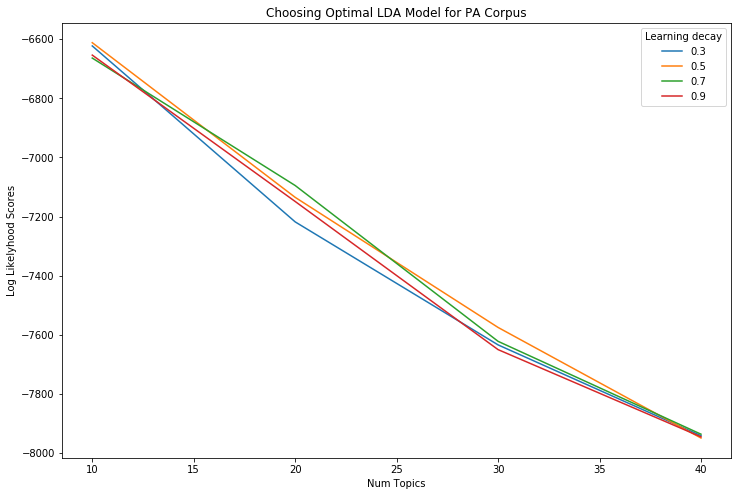

In [38]:
# Get Log Likelyhoods from Grid Search Output in PA
n_topics = [10, 20, 30, 40]
log_likelyhoods_3 = [round(model_pa.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_pa.cv_results_['params']) if gscore['learning_decay']==0.3]

log_likelyhoods_5 = [round(model_pa.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_pa.cv_results_['params']) if gscore['learning_decay']==0.5]

log_likelyhoods_7 = [round(model_pa.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_pa.cv_results_['params']) if gscore['learning_decay']==0.7]

log_likelyhoods_9 = [round(model_pa.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_pa.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model for PA Corpus")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [39]:
print("Optimal LDA Parameters for YT corpus:")
model_yt, best_lda_model_yt, data_vectorized_yt, vectorizer_yt = get_optimized_lda(yt_group)

Optimal LDA Parameters for YT corpus:
Sparsicity:  3.286978508217446 %
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -6065.746486951676
Model Perplexity:  105.71715092564826


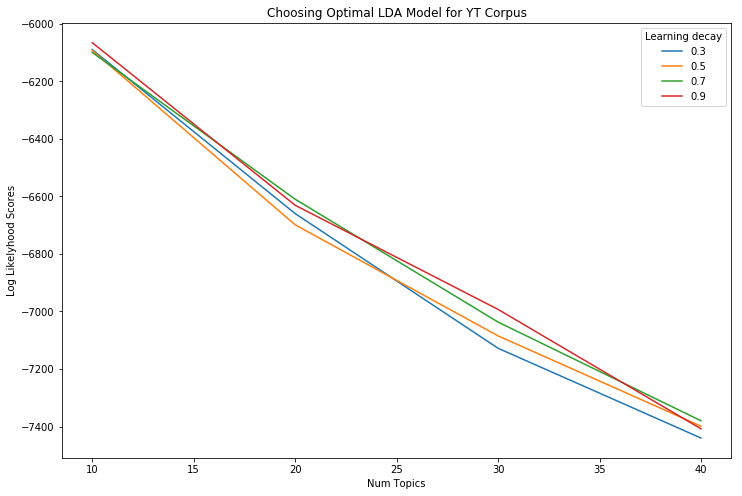

In [40]:
# Get Log Likelyhoods from Grid Search Output in YT
n_topics = [10, 20, 30, 40]
log_likelyhoods_3 = [round(model_yt.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_yt.cv_results_['params']) if gscore['learning_decay']==0.3]

log_likelyhoods_5 = [round(model_yt.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_yt.cv_results_['params']) if gscore['learning_decay']==0.5]

log_likelyhoods_7 = [round(model_yt.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_yt.cv_results_['params']) if gscore['learning_decay']==0.7]

log_likelyhoods_9 = [round(model_yt.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model_yt.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model for YT Corpus")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [41]:
print("Sentence-topic matrix for PA corpus:")
df_document_topics_pa, df_document_topic_pa, topicnames_pa = create_document_topic_matrix(best_lda_model_pa, data_vectorized_pa)

df_document_topics_pa

Sentence-topic matrix for PA corpus:


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Sentence_0,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,7
Sentence_1,0.5,0.27,0.01,0.01,0.01,0.01,0.14,0.01,0.01,0.01,0
Sentence_2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0
Sentence_3,0.03,0.03,0.03,0.37,0.37,0.03,0.03,0.03,0.03,0.03,3
Sentence_4,0.62,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.22,0.02,0
Sentence_5,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8
Sentence_6,0.01,0.51,0.01,0.19,0.01,0.01,0.01,0.01,0.22,0.01,1
Sentence_7,0.01,0.01,0.01,0.01,0.01,0.01,0.37,0.01,0.01,0.51,9
Sentence_8,0.03,0.03,0.77,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
Sentence_9,0,0,0.73,0,0,0,0,0,0.11,0.13,2


In [42]:
print("Participant answer with maximum value to corresponding topic in PA corpus:")
topic_sentence_map_pa = dict()
topics = list(df_document_topic_pa.columns.values)
topics = topics[0: len(topics)-1]
# iterate through the topics to find the most significant participant's sentence related to the topic in pa corpus
for topic in topics:
    index = df_document_topic_pa[topic].argmax().split("_")[1]
    maximum_value = df_document_topic_pa[topic].max()
    sentence = pa_group[int(index)]
    sentence = sentence.split("P:")[1]
    topic_sentence_map_pa.update({
        topic:{
            "value": maximum_value,
            "sentence": sentence   
        }
    })
# uncomment line below to see full sentences
pd.set_option('display.max_colwidth', -1)
pd.DataFrame.from_dict({(i): topic_sentence_map_pa[i] for i in topic_sentence_map_pa.keys()}, orient='index')

Participant answer with maximum value to corresponding topic in PA corpus:


,value,sentence
Topic0,0.95,"Actually I do ,I mostly comment because he's afro-american and I think coming from an Al Jazeera perspective, I think those stories are still getting covered but not in a way I think afro-Americans want them to be covered, so they need more attention. And to me it’s not very surprising that that is his top engagement story, yeah. Ok but here is the other question, so the user campaign is to increase our engagement, right? But what kind of content are we creating? Because based on my emails to my colleagues, we still need to pin down what we’re going to choose."
Topic1,0.94,"So, that was what that second screen, which I kind of ignore it and thought it's not that useful for me in terms of which , so basically there was that second screen which lists the videos yeah, but I think it would have been better to say.. sort of , actually list for this persona , for these types is what , for this kind of videos is what , for this persona, these types of videos is what ,"
Topic2,0.94,"They are interested in politics, social media, research, and social issues. The top three videos for them were Bangladesh, AJE live and China's rich girls, which showed that they are interested in controversial social issues in Asia, and surprisingly not a lot on their local issues, economies."
Topic3,0.87,His average video viewing time is about 10.9 minutes. That's also good for us.
Topic4,0.95,"The second one was more wordy, it was more ,it had words, it had titles, it was in boxes. It's almost as if you open your cupboard and you've got your spices in boxes and then you know what you're looking for, it's either in this box or that box, whereas the other one it's like you’ve got ,it is more like everything is ,it's not even labelled, you have to move. Let me give this example, just staying with that spice thing, if you don't know what you're looking for, then analytical is almost like I give you the actual spices dried up and you have to look by look to see what you are looking for, whereas the other one it gave you by name, so if you know what you're looking for, you look at the name of the spice."
Topic5,0.92,"Yeah. What is something else you recall about the ,. the second one was a new story. So that's why I don't remember. What is something else you recall about the persona? He was 22. College Grad. Sales. You know what that means. Well, black. That's probably ,."
Topic6,0.96,"Okay. Interested in General news. World news. Audience sizes. Okay. We have the audience size. Okay. I didn't catch the audience size. So here by numbers, I have 770K. Okay. But what is this? Audience size? Current reach? Where is the current reach? It should like a pop-up information explaining the current reach."
Topic7,0.95,"Just because it was like saying, like this is like the demo, you know, like this is just like a snapshot, a demo and just seeing that it's like ,it was like it put too much of a face on the demo, as opposed to saying here are some numbers, take from this what you will. Instead it was more like, you know, just like I didn't really ,like that demo didn’t really speak to me. I mean I guess it's just as an oversimplification of a demo it seems, I don't know."
Topic8,0.97,"I'm just sort of glancing over the information that's been presented to me and I'm just sort of hoping that I'm going to glean the information that I need to glean from what is just like, what I guess is a snapshot of the things that for instance Phil here is interested in and least interested in. Alright, so research, innovation, elections, news. He likes to read about research and innovation, elections, news, Iraq. Can you speak to the fact of whether or not this is like actual ,this is an actual representation of this service? If Phil is representative of an African-American male who is 22 years old from the United States. Are these the things that he’s reading about?"
Topic9,0.91,"Ok, I want to say like find the content that is somehow similar to ,and topic 

In [43]:
print("Sentence-topic matrix for YT corpus:")
df_document_topics_yt, df_document_topic_yt, topicnames_yt = create_document_topic_matrix(best_lda_model_yt, data_vectorized_yt)
df_document_topics_yt

Sentence-topic matrix for YT corpus:


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Sentence_0,0.02,0.02,0.37,0.47,0.02,0.02,0.02,0.02,0.02,0.02,3
Sentence_1,0.52,0.01,0.01,0.39,0.01,0.01,0.01,0.01,0.01,0.01,0
Sentence_2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0
Sentence_3,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0
Sentence_4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0
Sentence_5,0.03,0.03,0.03,0.7,0.03,0.03,0.03,0.03,0.03,0.03,3
Sentence_6,0.03,0.53,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.27,1
Sentence_7,0.01,0.01,0.32,0.4,0.01,0.09,0.15,0.01,0.01,0.01,3
Sentence_8,0.02,0.02,0.02,0.02,0.02,0.28,0.02,0.56,0.02,0.02,7
Sentence_9,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,6


In [44]:
print("Participant answer with maximum value to corresponding topic in YT corpus:")
topic_sentence_map_yt = dict()
topics = list(df_document_topic_yt.columns.values)
topics = topics[0: len(topics)-1]
# iterate through the topics to find the most significant participant's sentence related to the topic in yt corpus
for topic in topics:
    index = df_document_topic_yt[topic].argmax().split("_")[1]
    maximum_value = df_document_topic_yt[topic].max()
    sentence = yt_group[int(index)]
    sentence = sentence.split("P:")[1]
    topic_sentence_map_yt.update({
        topic:{
            "value": maximum_value,
            "sentence": sentence   
        }
    })
pd.DataFrame.from_dict({(i): topic_sentence_map_yt[i] for i in topic_sentence_map_yt.keys()}, orient='index')

Participant answer with maximum value to corresponding topic in YT corpus:


,value,sentence
Topic0,0.94,"I'm looking ,I'm trying to see if I can just look on age, but I think I'm just going to leave it. Ok, male, Jordan. Ok, so I looked up Jordan again and it's for the past 90 days but I'm going to look ,"
Topic1,0.94,"We're doing very bad as far as 25 to 34-year-old age group is concerned. They have more than double our audience. There might be something to be done in that area especially given the fact that most of , I mean the age segment between 18 to 24 have more free time on their hands and many tend to be college students. So I am surprised that college students don't have the time or aren't willing to tune in to the news as much as 25 to 34-year-olds."
Topic2,0.91,". Gender, so 80% male, suggest videos. What does that mean, suggested videos? So it's basically videos that come under other videos? So I can type in Jordan here?"
Topic3,0.95,"So it's similar to that one? So why I'm entering the analytics of when not helpful for me to understand like a female, female ,sorry, male from 18 to 24 in the US, people who lives in the US. I don't have enough data about those people. So what content should they be interested? Unless I want Arabic speakers, so I need to target the Arabic speakers. It could be for me I need to target Arabic speakers."
Topic4,0.90,"I'm trying to see if we can get the content consumption by the target personas, but it seems that we can only get it by geography. I'm sorry, I can't talk because I'm trying to concentrate for the questions, it's difficult to talk and concentrate at the same time."
Topic5,0.94,"Amazing. And you know – sorry to cut you off, there is companies that are selling clothes that are using this tool, it's like Minority Report, you know when he's walking in and then you know, that's exactly how it is, there is a guy. And you can click and you can like blow up the material on his jacket, things like that. It's very interesting, they're very smart, they know how to ,because that means a customer will probably click to buy it or something, you know."
Topic6,0.94,"Audience retention. Okay. So you can see roughly the percentage of the program was actually huge. People don't really watch more than halfway, give or take. Okay. 18 to 24. Watch Time. . Okay. Gender. More men than women. Good. That's to be expected."
Topic7,0.94,"I'm looking at which packages people from ,which video packages people from this region Cairo like the most, watch the most. Apparently it's pigeons, pigeon battles and Cairo, then there is Bangladesh's Biggest Brothel which is a 101 East special, then what happened to Saudi journalist Jamal , and only two Jordan related ones come up in the top 1 2 3 4 5 6 7 8 9 10, which is Jordan floods. But engagement, much time was higher for story on Egypt, which I find interesting."
Topic8,0.94,". Target group is ,Target 8% by suggested videos and the third largest group in terms of views in Jordan, no it's second largest group in terms of use, the third most ,it is the third largest group in terms of the watched ,this went off."
Topic9,0.90,"The watch time on average. Okay. I almost understood Celtic. For the watch time of those 74 million minutes watched it ,"


In [45]:
print("Topics distribution over sentences in PA corpus:")
df_topic_distribution_pa = get_topic_distribution_over_documents(df_document_topic_pa)
df_topic_distribution_pa

Topics distribution over sentences in PA corpus:


,Topic Number,Number of Sentences
0,0,326
1,4,89
2,1,86
3,5,63
4,7,62
5,2,62
6,9,61
7,3,60
8,8,50
9,6,38


In [46]:
print("Topics distribution over sentences in YT corpus:")
df_topic_distribution_yt = get_topic_distribution_over_documents(df_document_topic_yt)
df_topic_distribution_yt

Topics distribution over sentences in YT corpus:


,Topic Number,Number of Sentences
0,0,278
1,5,81
2,2,75
3,9,64
4,6,62
5,3,54
6,7,51
7,4,48
8,8,43
9,1,35


In [47]:
print("Visualization of topics and most influencial words in the topics in PA corpus:")
pa_panel = visualize_lda_model(best_lda_model_pa, data_vectorized_pa, vectorizer_pa)
filename = 'Output/lda_pa.html'
pyLDAvis.save_html(pa_panel, filename)
pyLDAvis.display(pa_panel)

Visualization of topics and most influencial words in the topics in PA corpus:


In [48]:
print("Visualization of topics and most influencial words in the topics in YT corpus:")
yt_panel = visualize_lda_model(best_lda_model_yt, data_vectorized_yt, vectorizer_yt)
pyLDAvis.save_html(yt_panel, 'Output/lda_yt.html')
pyLDAvis.display(yt_panel)

Visualization of topics and most influencial words in the topics in YT corpus:


In [49]:
print("Weights of each keyword in each topic in PA corpus:")
df_topic_keywords_pa = get_topic_keywords(best_lda_model_pa, vectorizer_pa, topicnames_pa)
df_topic_keywords_pa.head()

Weights of each keyword in each topic in PA corpus:


,actually,age,american,analytic,audience,average,base,big,click,college,...,united,use,video,view,want,watch,work,write,year,youtube
Topic0,20.876842,21.882213,6.800952,0.100003,0.100010,0.100038,6.098509,0.100003,11.023567,0.100012,...,14.395523,0.100002,0.100005,0.100018,5.928497,4.361473,0.100006,0.100006,0.100015,0.100007
Topic1,2.375694,14.842964,4.803113,0.100003,1.108893,0.100005,0.100012,0.100006,0.100000,0.100004,...,0.100010,0.100007,33.382366,0.100012,0.100015,1.563242,0.100005,0.100005,0.100001,0.100035
Topic2,0.100009,0.100021,4.483759,0.100003,0.100008,0.100003,5.592483,6.364073,0.100003,3.329233,...,0.100012,0.100003,9.935519,16.863147,0.100003,1.125670,4.164796,0.100005,0.100005,0.100006
Topic3,0.100006,0.100009,0.100011,0.100001,0.100009,19.556150,6.608956,0.100016,0.100006,0.100008,...,0.100013,0.100003,18.620406,25.022265,0.100022,33.069299,7.853052,0.100001,0.100010,0.100007
Topic4,0.100000,0.100004,0.100004,13.682260,7.058387,0.100012,0.100000,0.100002,0.100007,0.100004,...,0.100007,16.858224,0.100018,0.100016,5.797140,0.100042,14.308138,0.100009,0.100002,41.439730


In [50]:
print("Weights of each keyword in each topic in YT corpus:")
df_topic_keywords_yt = get_topic_keywords(best_lda_model_yt, vectorizer_yt, topicnames_yt)
df_topic_keywords_yt.head()

Weights of each keyword in each topic in YT corpus:


,actually,age,analytic,audience,average,big,bit,channel,click,come,...,view,viewer,want,watch,way,woman,work,write,year,youtube
Topic0,0.100002,19.345478,0.100011,9.601904,0.100009,1.899581,0.100008,0.100011,0.100004,0.100018,...,0.753745,0.107056,1.987891,8.100285,0.100001,5.099991,0.100007,0.100004,0.100007,38.664041
Topic1,0.100003,8.477135,0.100010,1.775596,0.100004,0.100049,0.100014,0.100004,0.100011,0.100002,...,1.363123,0.100000,1.236960,0.100010,0.100007,0.100000,0.100000,0.100001,38.095536,0.100002
Topic2,0.100003,16.326508,0.100014,0.100023,0.100001,1.378289,0.100006,6.695815,0.100015,2.619588,...,0.100042,12.052306,30.242829,26.570375,0.100000,0.100014,0.100001,0.100000,0.104432,0.100015
Topic3,0.100005,1.533776,1.151134,46.012669,0.100002,0.100011,0.100039,0.100063,0.100003,27.070178,...,15.219778,0.100015,9.876116,0.100018,0.100003,0.100000,2.382212,0.100004,0.100002,2.066125
Topic4,0.100011,0.100011,0.100009,1.519568,0.100002,0.100006,0.100019,0.100000,0.100002,0.100004,...,0.100004,0.100000,0.100002,4.261375,1.252975,0.100004,0.100071,0.100005,0.100000,0.100009


In [51]:
print('Top 10 keywords in each topic in PA corpus:')
df_topic_keywords_pa = get_top_ten_keywords_in_topics(best_lda_model_pa, vectorizer_pa)
df_topic_keywords_pa

Top 10 keywords in each topic in PA corpus:


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,right,don,think,say,age,actually,know,search,male,state
Topic 1,target,group,think,video,interested,news,persona,age,man,important
Topic 2,social,medium,interested,politic,really,people,issue,news,syria,view
Topic 3,good,minute,watch,time,view,average,maybe,video,refugee,relation
Topic 4,look,youtube,just,thing,know,persona,use,don,work,analytic
Topic 5,know,like,interesting,topic,college,year,just,title,relate,grad
Topic 6,audience,size,write,reach,general,person,current,persona,compare,guy
Topic 7,just,jordan,remember,number,think,egypt,understand,know,don,didn
Topic 8,read,persona,like,research,old,innovation,live,year,stuff,information
Topic 9,interested,content,innovation,research,mean,thank,election,want,similar,say


In [52]:
print('Top 10 keywords in each topic in YT corpus:')
df_topic_keywords_yt = get_top_ten_keywords_in_topics(best_lda_model_yt, vectorizer_yt)
df_topic_keywords_yt

Top 10 keywords in each topic in YT corpus:


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,just,youtube,jordan,look,man,try,age,gender,let,tell
Topic 1,year,remember,segment,old,easy,age,topic,mean,just,compare
Topic 2,male,jordan,video,demographic,want,watch,thank,age,female,viewer
Topic 3,look,audience,people,come,content,target,need,try,male,view
Topic 4,information,sure,try,use,interested,persona,time,difficult,news,country
Topic 5,know,don,state,maybe,united,didn,really,look,select,mean
Topic 6,think,good,video,actually,write,watch,youtube,way,jordanian,interested
Topic 7,jordan,analytic,interesting,interested,happen,write,email,great,story,look
Topic 8,group,video,comment,watch,thing,target,term,make,age,view
Topic 9,watch,time,view,minute,say,video,average,look,total,click
